In [1]:
import patient as p
import tensorflow as tf
import numpy as np
import myLib
import consts as c



In [2]:
c.WINDOW_SIZE = 3500

tabSegments = []
for pStr in c.trainPatients:
    currPatient = p.patient(pStr)
    tabSegments = tabSegments + currPatient.getPositveSegmentsAdvanced() + currPatient.getNegativeSegments()


x_train,y_train = myLib.processDF(tabSegments)

x_test,y_test,x_validation,y_validation = myLib.getTrainValData()




Expected 7681.0 got 7649
Expected 7681.0 got 7649
Expected 7681.0 got 7649
Expected 7681.0 got 7265
Expected 7681.0 got 7489
Expected 7681.0 got 6114
Expected 7681.0 got 7649
Expected 7681.0 got 7585
Expected 7681.0 got 7585
Expected 7681.0 got 7649
Expected 7681.0 got 7649
Expected 7681.0 got 7617
Expected 7681.0 got 6314
Expected 7681.0 got 7649
Expected 7681.0 got 7649
Expected 7681.0 got 7617
Expected 7681.0 got 6314
Expected 7681.0 got 7649
Expected 7681.0 got 7617


In [3]:
print(f"train data: {len(x_train)}\t validation: {len(x_validation)}\t test:{len(x_test)}\n")
unique, counts = np.unique(y_train, return_counts=True)

print(f"TRAIN:     Negatives: {counts[0]} Positives: {counts[1]}")
pos = counts[1]
neg = counts[0]
ratio = round(100 / len(x_train) * pos)
unique, counts = np.unique(y_validation, return_counts=True)
print(f"VALIDATION Negatives: {counts[0]} Positves: {counts[1]}")
unique, counts = np.unique(y_test, return_counts=True)
print(f"TEST       Negatives: {counts[0]} Positves: {counts[1]}")


print(f"\n{ratio} % of positives")




train data: 933	 validation: 24	 test:182

TRAIN:     Negatives: 660 Positives: 273
VALIDATION Negatives: 12 Positves: 12
TEST       Negatives: 91 Positves: 91

29 % of positives


In [4]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def getModel2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(x_train.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model



In [5]:
model = getModel2()

TrainHistory = model.fit(
    x_train,
    y_train,
    epochs=c.EPOCHS,
    batch_size=c.BATCH_SIZE,
    validation_data=(x_validation, y_validation), 
    verbose=0)

Test accuracy: 0.549


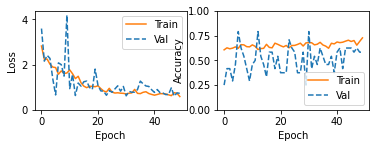

In [6]:
import matplotlib.pyplot as plt


def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color="C1", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="C0", linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(TrainHistory)
evalutation = model.evaluate(x_test,y_test,verbose=False)
print(f"Test accuracy: {round(evalutation[3],3)}")

In [7]:
myLib.safeRun(model,"Unbalanced",x_train,x_validation,x_test,y_test,"UnbalancedChannelCombined.csv")